In [ ]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard


In [ ]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise
  
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    # output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

def add_gaussian_blur(data):
    dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
    return dst

In [ ]:
# clone sample images

image_dir = 'data/images'
sys.path.append(image_dir)

images = os.listdir(image_dir)
print(images)


Cloning into 'dataAE'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 1), reused 34 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.
['28.jpg', '13.jpg', '26.jpg', '24.jpg', '21.jpg', '25.jpg', '19.jpg', '16.jpg', '20.jpg', '14.jpg', '1.jpg', '6.jpg', '5.jpg', '12.jpg', '27.jpg', '22.jpg', '10.jpg', '7.jpg', '2.jpg', '18.jpg', '3.jpg', '4.jpg', '17.jpg', '15.jpg', '9.jpg', '11.jpg', '23.jpg', '8.jpg']


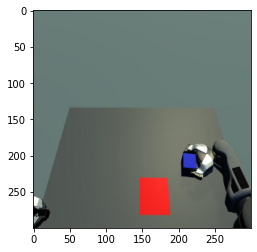

In [ ]:
# create tensor batch of images
height = 300#480
width = 300#640

image_batch = []
for rgb in images:
  image = plt.imread(os.path.join(image_dir, rgb))
  image = cv2.resize(image, (width, height))
  # image = image / 255.0

  image_batch.append(image)
  

# stack images onto new channel
# image_batch = tf.stack(image_batch)
# print(image_batch.shape)
# print(type(image_batch))


plt.imshow(image_batch[1])


In [ ]:
# resize the images
# image_batch = tf.image.resize(
#   image_batch, (320,320), method='nearest', preserve_aspect_ratio=False,
#   antialias=True, name=None)
  
# print(image_batch.shape)
# plt.imshow(image_batch[1,:])

In [ ]:

# image_batch = image_batch/ 255

# #split test and train dataset
# ##USE SKLEARN  from sklearn.model_selection import train_test_split -- see mask-rcnn method
# train_ds, test_ds = tf.split(image_batch, num_or_size_splits=2, axis=0)
# tf.shape(train_ds).numpy()


ds = tf.stack(image_batch)
print(ds.shape)


(28, 300, 300, 3)


In [ ]:

train_ds = ds[1:25,:]
test_ds = ds[25:,:]

print(train_ds.shape, test_ds.shape)



(24, 300, 300, 3) (3, 300, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(24, 300, 300, 3)


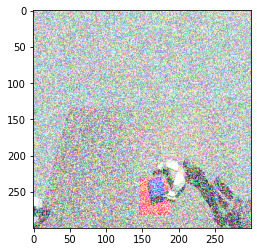

In [ ]:
gaussian_train_ds = add_gaussian_to_dataset(train_ds)
gaussian_test_ds = add_gaussian_to_dataset(test_ds)

plt.imshow(gaussian_train_ds[1,:])
print(gaussian_train_ds.shape)



In [ ]:
# rescaled data

# train_ds = train_ds.astype('float32') / 255.0
# test_ds = test_ds.astype('float32')  / 255.0

train_ds = train_ds / 255
test_ds = test_ds / 255

# # reduce images
gaussian_train_ds = gaussian_train_ds / 255.0 
gaussian_test_ds = gaussian_test_ds / 255.0



In [ ]:
#constuct the autoencoder model 

def create_model():
  x = Input(shape=(width, height, 3)) 

  latent_dim = 64

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # encoder = layers.Flatten()(h),
  # encoder = layers.Dense(latent_dim, activation='relu')(encoder)

  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  # model.compile(optimizer='adam', loss='mse') #'binary_crossentropy'
  # model.compile(optimizer='adam', loss='binary_crossentropy')
  
  opt = keras.optimizers.Adam(learning_rate=0.001)
  # model.compile(loss='categorical_crossentropy', optimizer=opt)
  model.compile(loss='mse', optimizer=opt)


  return model

In [ ]:
gaussian_auto_encoder = create_model()
# gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_ds,
                                            train_ds, 
                                            epochs=100, 
                                            batch_size=16,
                                            shuffle=True,
                                            validation_data=(gaussian_test_ds, test_ds),
                                            callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=False)])
                                            #, gaussian_early_stop])


Epoch 1/100
2/2 [==============================] - 9s 3s/step - loss: 0.0206 - val_loss: 0.0185
Epoch 2/100
2/2 [==============================] - 8s 3s/step - loss: 0.0156 - val_loss: 0.0164
Epoch 3/100
2/2 [==============================] - 8s 3s/step - loss: 0.0145 - val_loss: 0.0165
Epoch 4/100
2/2 [==============================] - 8s 3s/step - loss: 0.0129 - val_loss: 0.0164
Epoch 5/100
2/2 [==============================] - 8s 3s/step - loss: 0.0126 - val_loss: 0.0159
Epoch 6/100
2/2 [==============================] - 8s 3s/step - loss: 0.0124 - val_loss: 0.0161
Epoch 7/100
2/2 [==============================] - 8s 3s/step - loss: 0.0123 - val_loss: 0.0162
Epoch 8/100
2/2 [==============================] - 8s 3s/step - loss: 0.0122 - val_loss: 0.0159
Epoch 9/100
2/2 [==============================] - 8s 3s/step - loss: 0.0120 - val_loss: 0.0160
Epoch 10/100
2/2 [==============================] - 8s 3s/step - loss: 0.0118 - val_loss: 0.0159
Epoch 11/100
2/2 [=====================

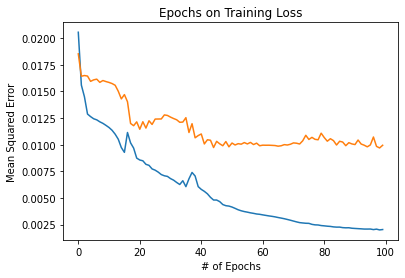

In [ ]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.plot(gaussian_history.epoch, gaussian_history.history['val_loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()



In [ ]:
# evaluate the model on the test set

result = gaussian_auto_encoder.predict(gaussian_test_ds)
gaussian_auto_encoder.evaluate(test_ds, gaussian_test_ds)


1/1 [==============================] - 0s 364ms/step - loss: 0.2836


0.283573716878891

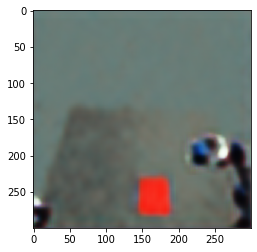

In [ ]:
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()


idx = 2

# plot_rgb_img(result[idx])
plt.imshow(result[idx])


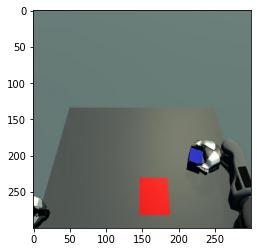

In [ ]:
plt.imshow(test_ds[idx])

In [ ]:
# !pip install --upgrade grpcio==1.34


In [ ]:
# ! tensorboard --logdir=/tmp/autoencoder --bind_all --load_fast=false --port 6000 